In [1]:
from read_experiments import *

In [2]:
print_runs()

runs
├── EXP acrobot_aux: 11
├── EXP acrobot_noaux: 10
├── EXP cartpole_aux: 10
├── EXP cartpole_noaux: 10
├── EXP invisible_1: 3
├── EXP invisible_shared0: 5
├── EXP invisible_shared1: 5
├── EXP invisible_shared2: 5
├── EXP mountaincar_aux: 10
├── EXP mountaincar_noaux: 10
├── EXP nav_aux_c2_wall_1: 5
├── EXP nav_aux_c2_wall_3: 5
├── EXP nav_aux_wall_1: 10
├── EXP nav_aux_wall_3: 10
├── EXP nav_euclid_c2_start_0: 5
├── EXP nav_euclid_c2_start_1: 6
├── EXP nav_euclid_c2_start_2: 6
├── EXP nav_euclid_start_0: 10
├── EXP nav_euclid_start_1: 10
├── EXP nav_euclid_start_2: 10
├── EXP nav_invisible_color_1_dist: 5
├── EXP nav_invisible_color_1_none: 5
├── EXP nav_invisible_color_2.5_dist: 5
├── EXP nav_invisible_color_2.5_none: 5
├── EXP nav_invisible_color_2_dist: 5
├── EXP nav_invisible_color_2_none: 5
├── EXP nav_invisible_color_4_dist: 5
├── EXP nav_invisible_color_4_none: 5
├── EXP nav_invisible_shared0: 5
├── EXP nav_invisible_shared1: 5
├── EXP nav_invisible_shared2: 4
├── EXP nav_vi

In [17]:
df['step'].max()

399840.0

In [6]:
for i in range(10):
    df = load_exp_df('nav_euclid_c2_start_2', i)
    print(i, df['step'].max())

0 399840.0
1 92832.0
2 399840.0
3 399840.0
4 399840.0
No experiments found


TypeError: 'NoneType' object is not subscriptable

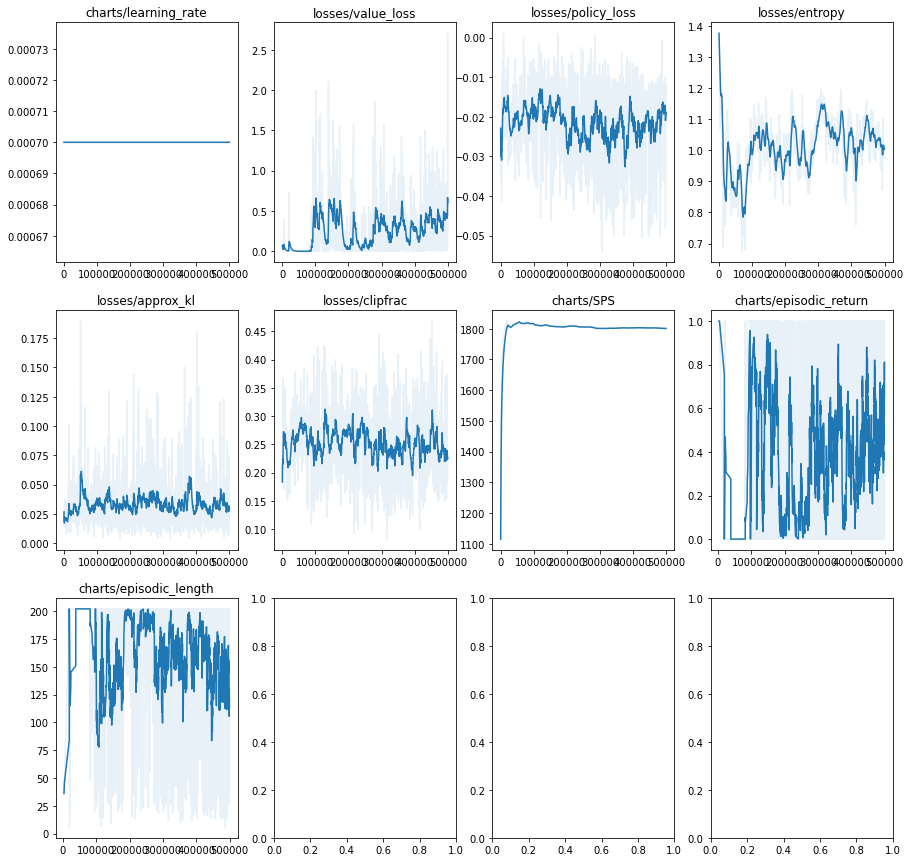

In [25]:
df = load_exp_df('nav_euclid_c2_start_', 3)

plot_exp_df(df)

In [11]:
df = load_exp_df('invisible_shared0')

In [15]:
df = df[df['metric'] == 'charts/episodic_return']

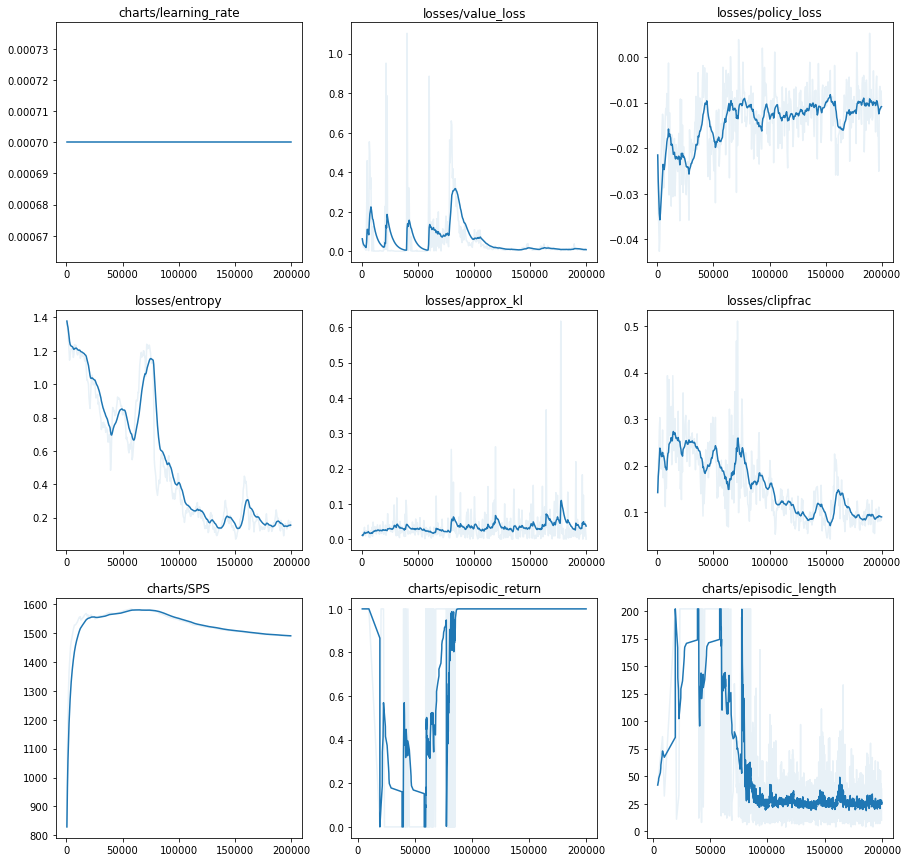

In [51]:
df = load_exp_df('nav_visible_none')
plot_exp_df(df)

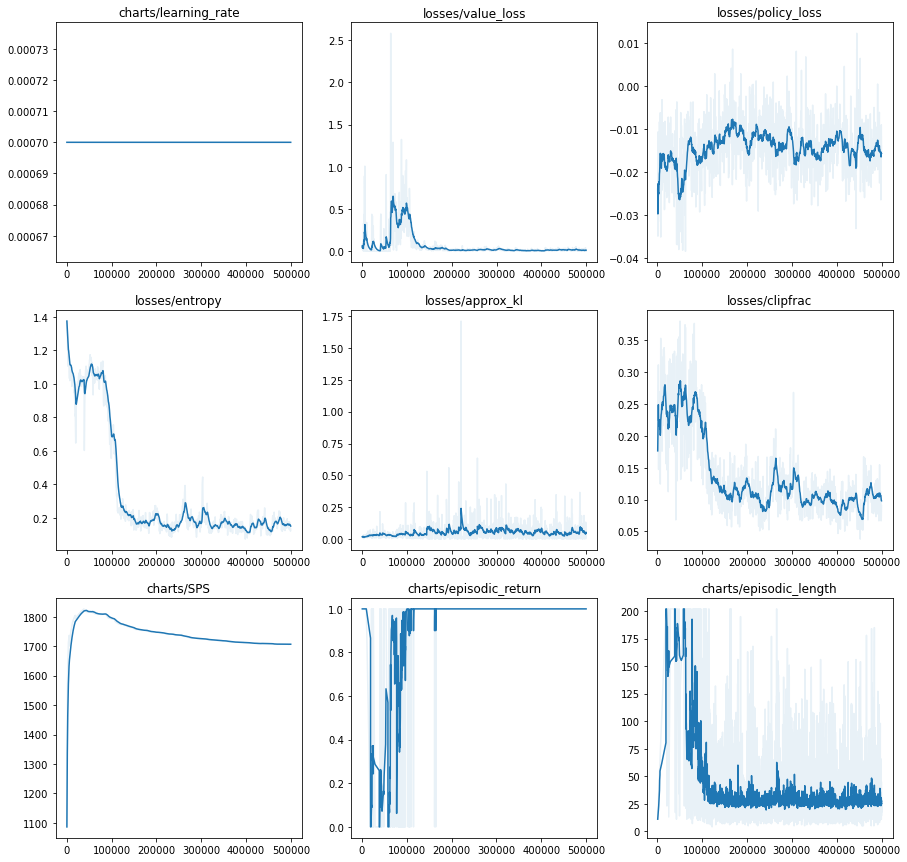

In [3]:
df = load_exp_df('nav_invisible_color_4_none')
plot_exp_df(df)

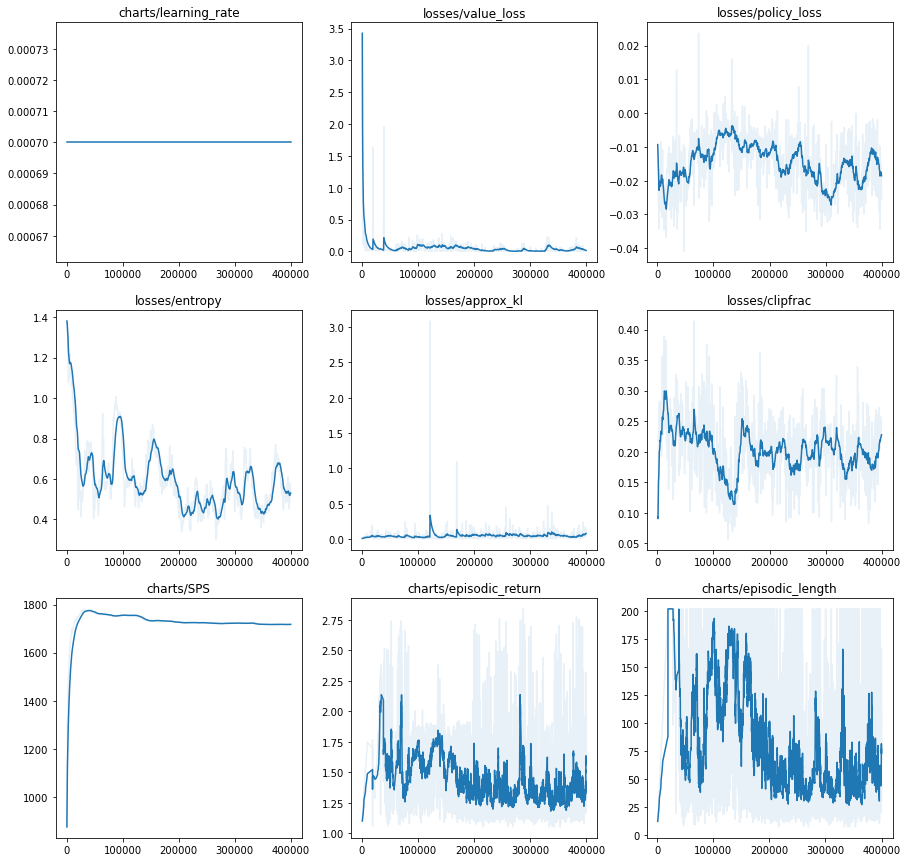

In [27]:
df = load_exp_df('nav_invisible_shared1', 4)
plot_exp_df(df)

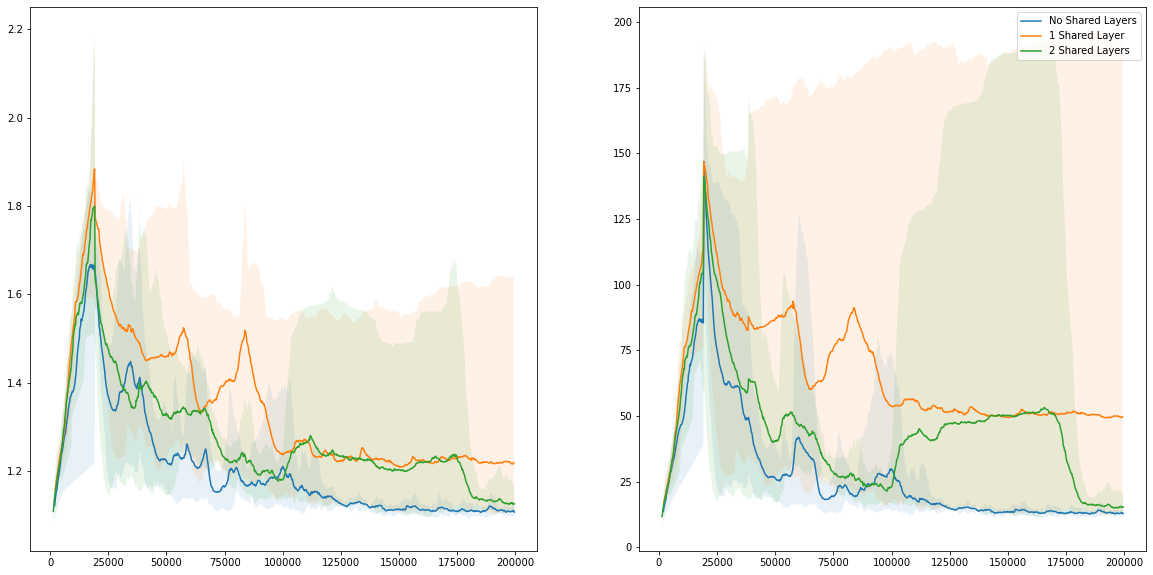

In [53]:
trial_names = ['invisible_shared0', 'invisible_shared1', 'invisible_shared2']
labels = ['No Shared Layers', '1 Shared Layer', '2 Shared Layers']

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
for i in range(3):
    average_runs(trial_names[i], metric='return', ax=ax[0], label=labels[i])
    average_runs(trial_names[i], metric='length', ax=ax[1], label=labels[i])

ax[1].legend()

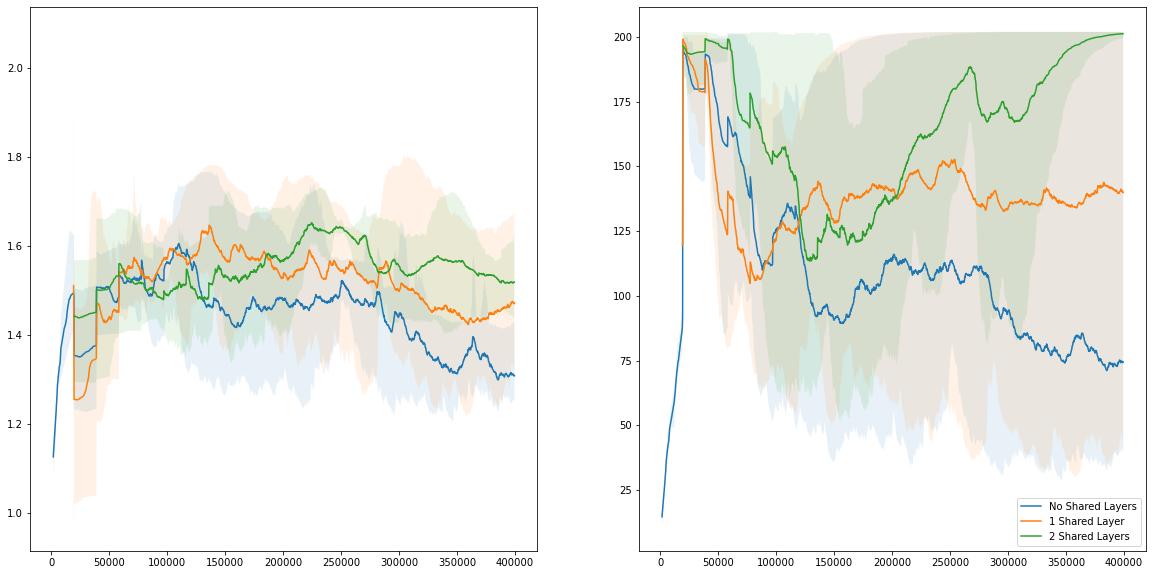

In [124]:
trial_names = ['nav_invisible_shared0', 'nav_invisible_shared1', 'nav_invisible_shared2']
labels = ['No Shared Layers', '1 Shared Layer', '2 Shared Layers']

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
for i in range(3):
    average_runs(trial_names[i], metric='return', ax=ax[0], label=labels[i])
    average_runs(trial_names[i], metric='length', ax=ax[1], label=labels[i])

ax[1].legend()

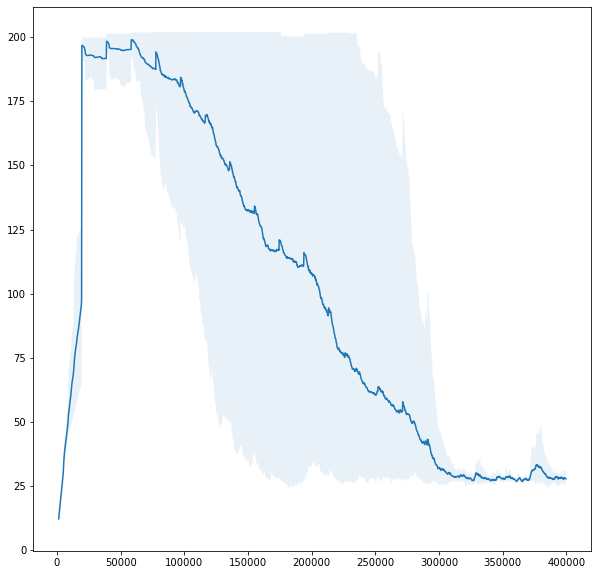

In [5]:
average_runs('nav_euclid_start_0', 'length')

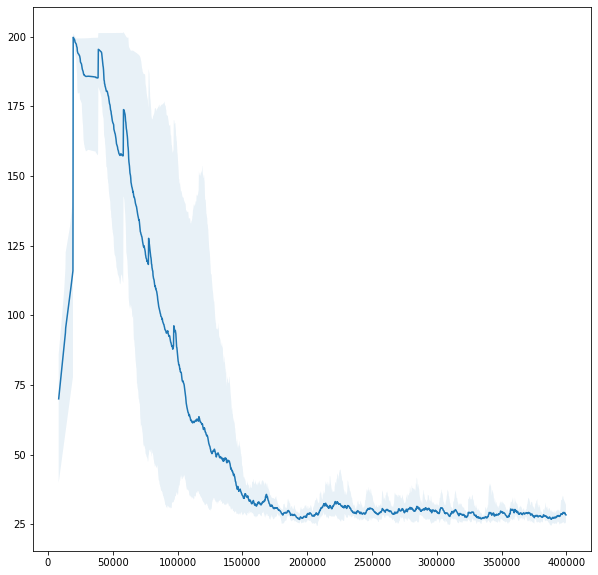

In [8]:
average_runs('nav_euclid_start_1', 'length')

In [4]:
print_runs(ret=False)

runs
├── acrobot_aux
├── acrobot_noaux
├── cartpole_aux
├── cartpole_noaux
├── EXP invisible_1: 3
├── EXP invisible_shared0: 5
├── EXP invisible_shared1: 5
├── EXP invisible_shared2: 5
├── mountaincar_aux
├── mountaincar_noaux
├── EXP nav_aux_wall_1: 10
├── EXP nav_aux_wall_3: 10
├── EXP nav_euclid_start_0: 10
├── EXP nav_euclid_start_1: 10
├── EXP nav_euclid_start_2: 10
├── EXP nav_invisible_color_1_dist: 3
├── EXP nav_invisible_color_2.5_dist: 5
├── EXP nav_invisible_color_2.5_none: 5
├── EXP nav_invisible_color_2_dist: 5
├── EXP nav_invisible_color_2_none: 5
├── EXP nav_invisible_color_4_dist: 5
├── EXP nav_invisible_color_4_none: 5
├── EXP nav_invisible_shared0: 5
├── EXP nav_invisible_shared1: 5
├── EXP nav_invisible_shared2: 4
├── EXP nav_visible_dist: 5
├── EXP nav_visible_none: 5
├── pendulum_aux
├── pendulum_noaux


{'acrobot_aux': 1,
 'acrobot_noaux': 1,
 'cartpole_aux': 1,
 'cartpole_noaux': 1,
 'invisible_1': 3,
 'invisible_shared0': 5,
 'invisible_shared1': 5,
 'invisible_shared2': 5,
 'mountaincar_aux': 1,
 'mountaincar_noaux': 1,
 'nav_aux_wall_1': 10,
 'nav_aux_wall_3': 10,
 'nav_euclid_start_0': 10,
 'nav_euclid_start_1': 10,
 'nav_euclid_start_2': 10,
 'nav_invisible_color_1_dist': 3,
 'nav_invisible_color_2.5_dist': 5,
 'nav_invisible_color_2.5_none': 5,
 'nav_invisible_color_2_dist': 5,
 'nav_invisible_color_2_none': 5,
 'nav_invisible_color_4_dist': 5,
 'nav_invisible_color_4_none': 5,
 'nav_invisible_shared0': 5,
 'nav_invisible_shared1': 5,
 'nav_invisible_shared2': 4,
 'nav_visible_dist': 5,
 'nav_visible_none': 5,
 'pendulum_aux': 1,
 'pendulum_noaux': 1}

IndexError: index 3 is out of bounds for axis 0 with size 3

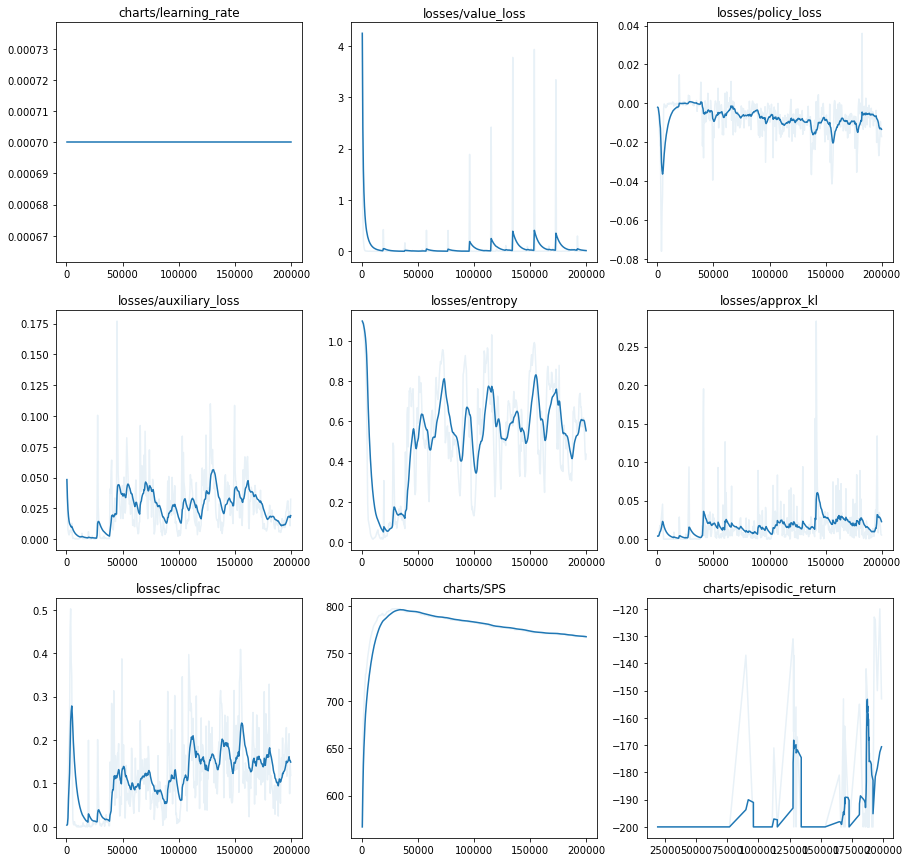

In [10]:
df = load_exp_df('mountaincar_aux')
plot_exp_df(df)

IndexError: index 3 is out of bounds for axis 0 with size 3

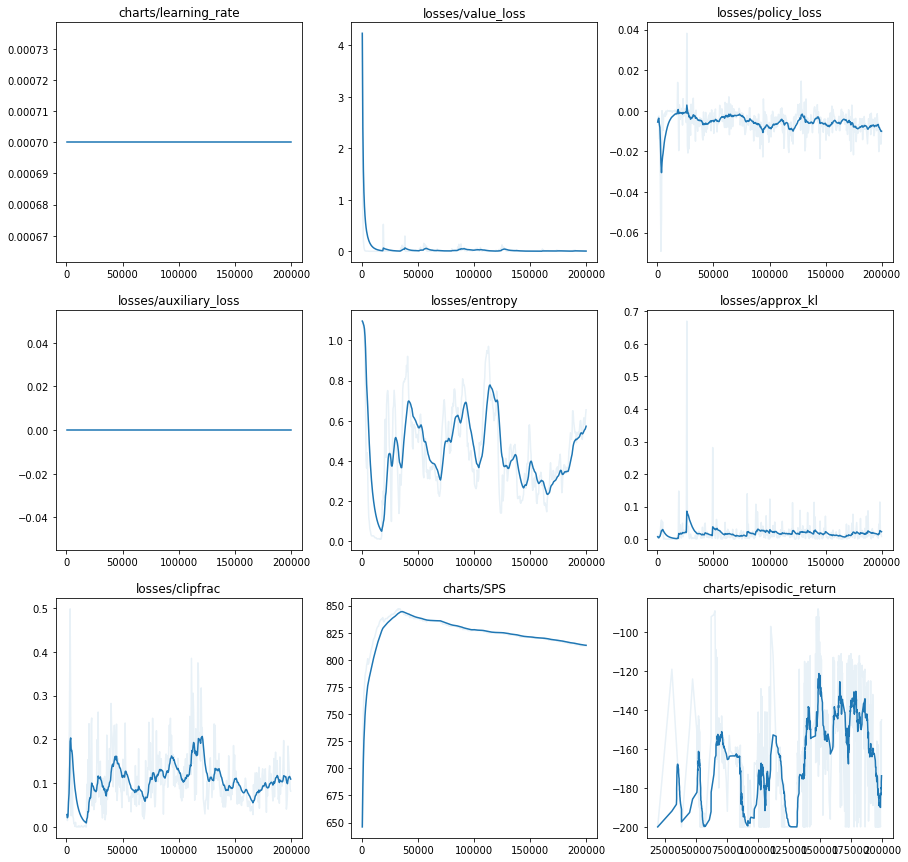

In [11]:
df = load_exp_df('mountaincar_noaux')
plot_exp_df(df)